#### Gorella Website Experimentation

This notebook is based on https://g0rella.github.io/gorella_mwn/preprocessing_eeg.html.
This is my experimentation on the code and information given there

In [1]:
import mne
import matplotlib
import numpy as np
# %matplotlib notebook

matplotlib.rcParams['figure.figsize'] = (10, 5)

In [2]:
# Loading one of the example datasets
path = mne.datasets.eegbci.load_data(3, 1)
path[0]     # list with one element in it, which is the path to the .edf file

WindowsPath('C:/Users/joelj/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R01.edf')

In [3]:
# Reading (importing) the EDF file
raw = mne.io.read_raw_edf(path[0], preload=True)
raw.info['chs']

Extracting EDF parameters from C:\Users\joelj\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S003\S003R01.edf...
EDF file detected


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


[{'cal': 1.0,
  'logno': 1,
  'scanno': 1,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'Fc5.',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])},
 {'cal': 1.0,
  'logno': 2,
  'scanno': 2,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'Fc3.',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])},
 {'cal': 1.0,
  'logno': 3,
  'scanno': 3,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'Fc1.',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])},
 {'cal': 1.0,
  'logno': 

In [4]:
raw.info     # summary

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

In [5]:
print("Sample rate: ", raw.info['sfreq'] )              # sampling freq = 160 Hz
# raw.info                        # 64 EEG channels
# raw.annotations                 # usually contains sleep stages or event markers
channel_names = raw.ch_names    # list of channel names
print("Channels: ", channel_names[:5], " ...")

Sample rate:  160.0
Channels:  ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.']  ...


Note: What is a channel? It is the time series data recorded from a single electrode.
Units: Typically microVolts

In [6]:
len(channel_names)              # should be 64, from .info

64

`raw.get_data()` returns a `np.array` of shape `(n_channels, n_times)` where `n_times` is the number of samples. So if we have EEG data over 10 seconds, at sampling rate of 1000 Hz, then `n_times` would be 10000 samples

##### Optional Parameters
- Picks:
  ```
  raw.get_data(picks='Fz')        # Only the 'Fz' channel
  raw.get_data(picks=['Fz', 'Cz'])  # Multiple channels
  ```
- Start, stop:
  `raw.get_data(start=1000, stop=2000)  # Data from 1s to 2s (at 1000 Hz)`
- return_times:
  `data, times = raw.get_data(picks='Fz', return_times=True) # Returns a time vector`

Note: `raw.get_data()` applies any preprocessing already done (e.g., filtering).

In [8]:
from mne.datasets import eegbci

# set channel names
eegbci.standardize(raw)     # rename all channels to the standard 10-20 system

Text(0, 0.5, 'Voltage (µV)')

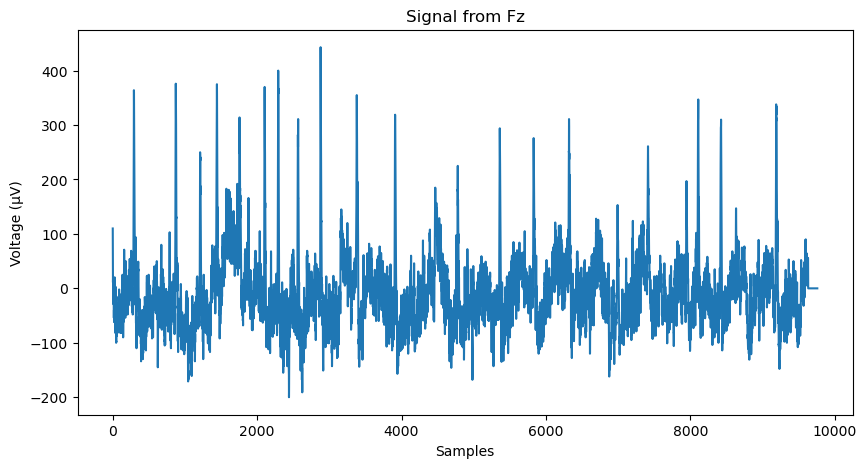

In [9]:
Fz_data = raw.get_data(picks='Fz')    # by default in volts (we need to rescale to microvolts)
import matplotlib.pyplot as plt
plt.plot(Fz_data[0] * 1e6)  # Convert from volts to µV
plt.title("Signal from Fz")
plt.xlabel("Samples")
plt.ylabel("Voltage (µV)")

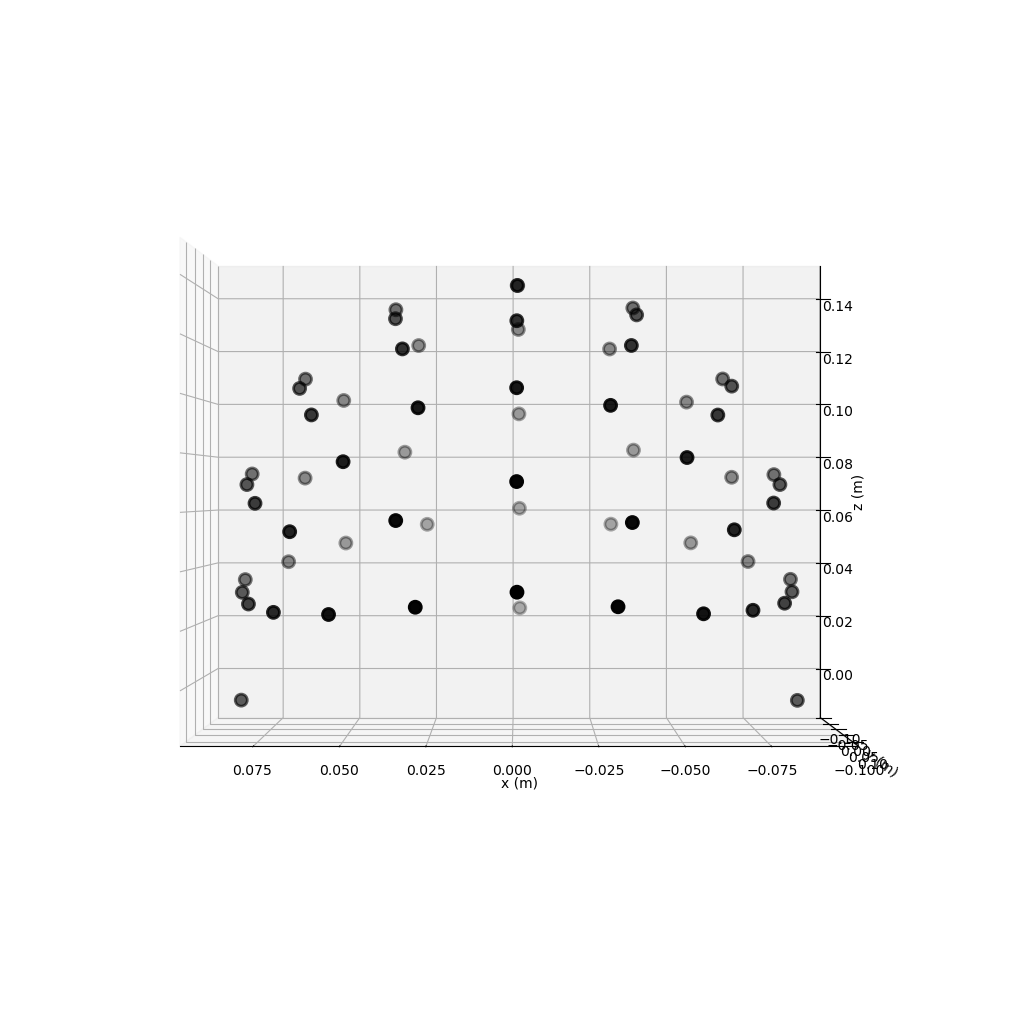

In [10]:
# displaying the 3D spatial locations for the electrodes

# set montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
raw.plot_sensors(kind='3d');

Using matplotlib as 2D backend.


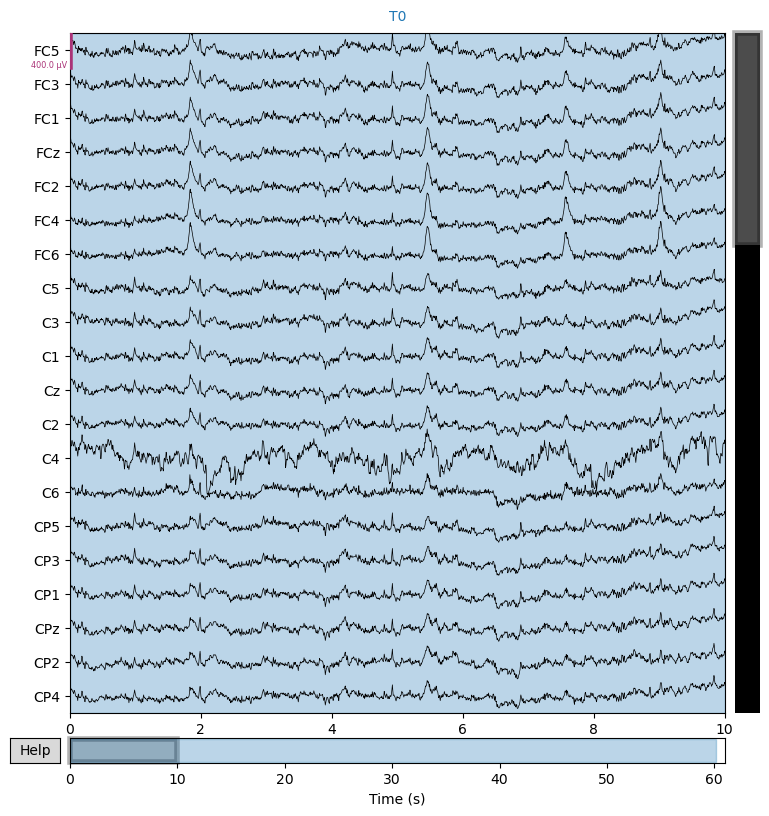

In [11]:
%matplotlib inline
raw.plot(scalings = dict(eeg=200e-6));  # +/- 200 µV scale (1 V = 1000000 µV)

#### What is PSD?
Power Spectral Density (PSD) tells how much power (signal strength) is present at each frequency in the signal, measured as an average over some time interval.

PSD is the "Fourier transform of the autocorrelation function" of that signal. (ToDo CHECK what this means)

Uses:
- To detect brain states (alpha, delta, theta, etc.). Dominant rhythm frequencies can be identified using PSD
- Can be used to infer cognitive or sleep states by observing which frequencies are dominant
- PSD change over time can be observed to see "state transitions" (?)
- **Artifact detection**: Non-brain sources appear as sharp peaks (ex: power-line noise around 60 Hz, clearly visible in the below PSD plot) Also eyeblinks/movements (~4 Hz)



##### EEG Is Recorded in Microvolts — So Where Does Frequency Come In?
EEG is a voltage signal over time.
You're recording changes in electrical potential (in µV) between electrodes on the scalp.
So your raw signal is:
V(t) → voltage as a function of time.
But EEG Isn’t Just Random Noise — It Has Rhythmic Patterns
These patterns oscillate — rise and fall like waves.

##### So What Does the Frequency Axis in PSD Mean?
When you compute Power Spectral Density, you're answering:
“How much of the total signal energy is concentrated at each frequency?”
This is done via Fourier Transform:
Any time-series signal (even brain waves) can be decomposed into a sum of sine and cosine waves at different frequencies.
PSD tells you which frequencies are dominant, and how strong they are.

##### What Does, ex: "Alpha = 10 Hz" Mean Physically?
Let’s say you see a peak at 10 Hz in your PSD.
This means that the brain's EEG signal contains a rhythmic fluctuation happening 10 times per second.
This is most often an alpha rhythm, typically linked to eyes-closed relaxed wakefulness.
It’s like the brain’s electrical activity is resonating at that frequency, often due to synchronized firing in cortical networks.

##### Where Do These Oscillations Come From?
Neurons don't just fire randomly. They:
Fire rhythmically in populations (especially cortical pyramidal neurons).
Create electric dipoles that can be detected on the scalp.
When large groups synchronize, you get clear rhythms at certain frequencies.
Each frequency band corresponds to different neural processes or brain states.

##### NOTE:
These frequencies are not frequencies of neuron firing (spikes per second).
Neurons fire at irregular rates, often higher than 10–100 Hz.
But local field potentials (LFPs) — collective electrical behavior — oscillate more slowly, and that’s what you’re measuring in EEG.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


c:\Users\joelj\anaconda3\envs\BCS\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


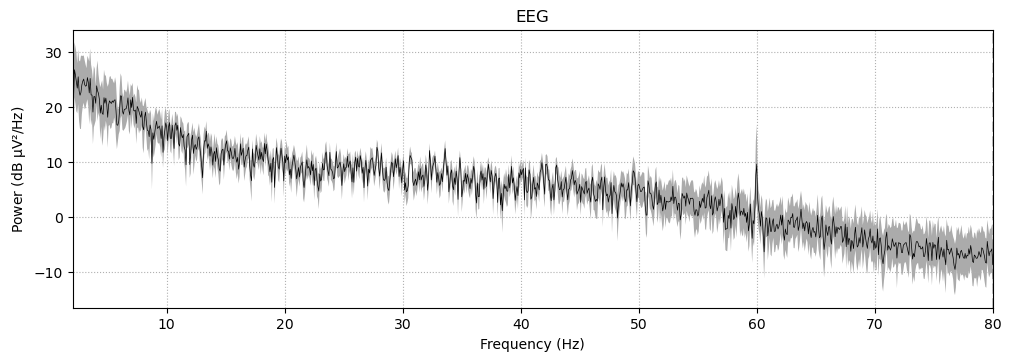

In [ ]:
# power spectral density plot of our data
%matplotlib inline
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);
'''
tmin to tmax (plots PSD over the time interval of tmin to tmax in seconds)
fmin, fmax (plots the PSD for the range of frequencies from fmin to fmax)
average -> Averaged across channels
'''

#### Filtering
- Clear spike at 60 Hz, this is the power-line interference->to “remove 60Hz” but keep other frequncies, we can use a "notch filter"

- Low-pass filter: only alows frequencies below a particular threshold, rest all is discarded

In [16]:
# set notch filter
raw.notch_filter(60)

raw.filter(l_freq=1.0, h_freq=50.0) # only keeping frequencies between 1-50 Hz

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawEDF | S003R01.edf, 64 x 9760 (61.0 s), ~4.9 MiB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


c:\Users\joelj\anaconda3\envs\BCS\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


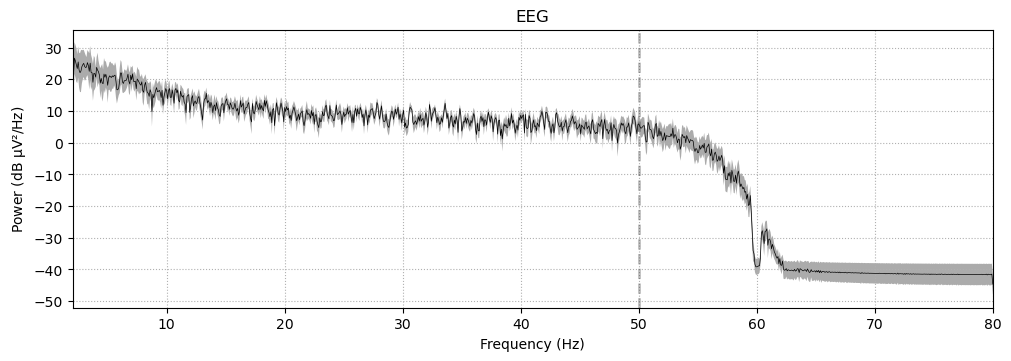

In [17]:
# See the difference in the PSD after filtering
%matplotlib inline
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);

Sampling frequency of the instance is already 120.0, returning unmodified.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 17.067 (s)
Plotting power spectral density (dB=True).


c:\Users\joelj\anaconda3\envs\BCS\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


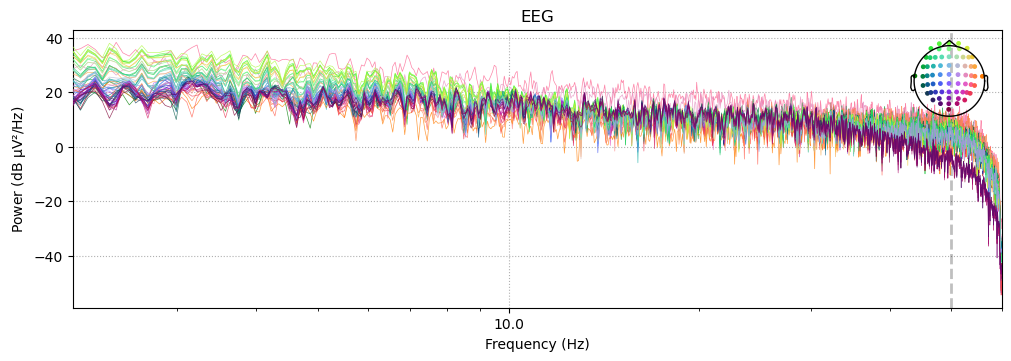

In [21]:
# raw.info['sfreq']      # this is the original sampling rate, it is 160 Hz


# Downsample a lot
raw.resample(120, npad='auto')  # converting the data from 160 to 120 Hz
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=60, average=False, spatial_colors=True, xscale='log');
# Notice that the max plotted frequency is 60, the nyquist rate!
# TODO: Read more about Nyquist Rate!!

#### Dealing with bad channels

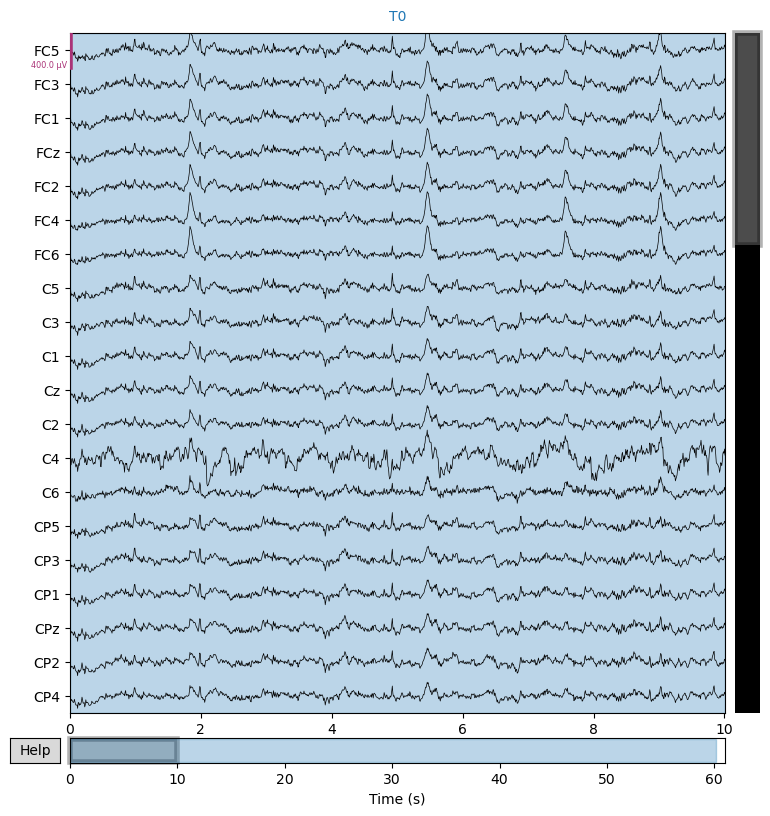

In [ ]:
# After filtering and downsampling, we can look at the raw data again to see if there are any bad channels:
raw.plot(scalings = dict(eeg=200e-6));

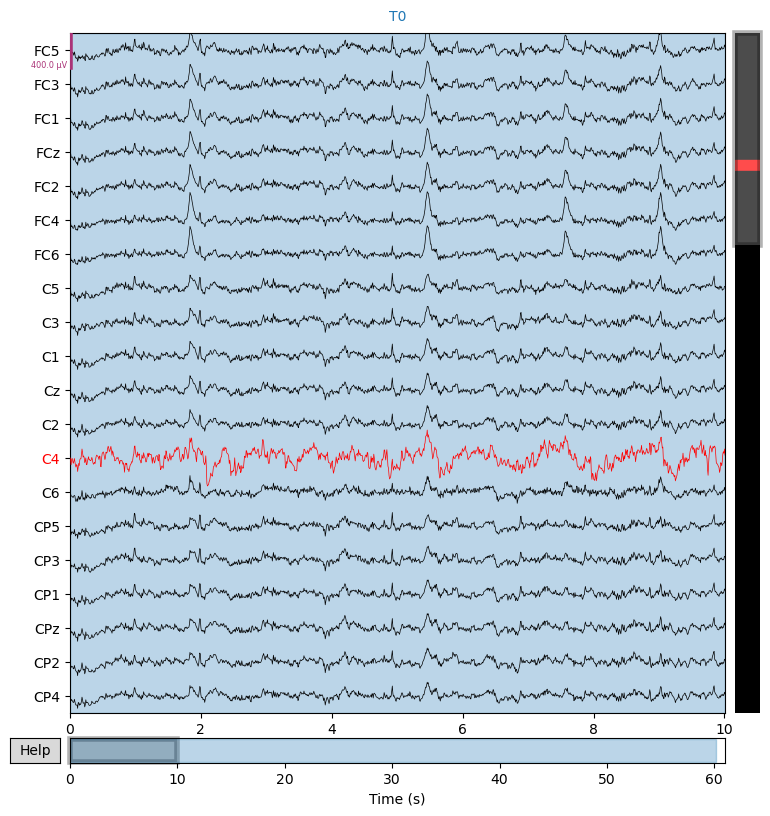

In [24]:
# Observe that channel C4 looks noisier than the others. We can then flag it as a ‘bad’ channel and remove it:
# raw.info['bads']  # currently empty
raw.info['bads'] = ['C4']
picks = mne.pick_types(raw.info, exclude='bads')
raw.plot(scalings=dict(eeg=200e-6), bad_color='red');

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.5 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors


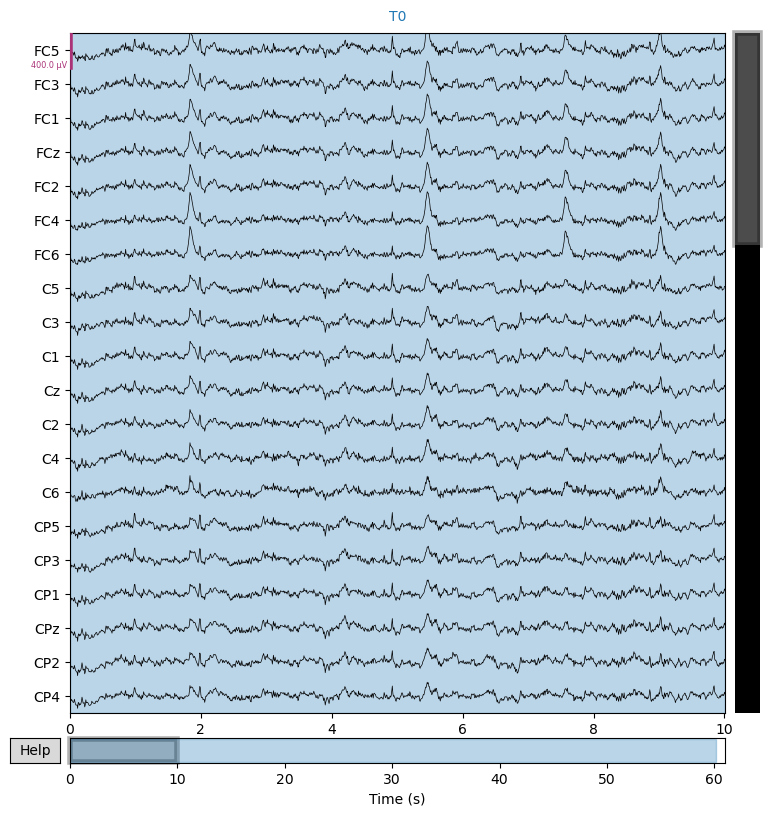

In [ ]:
# Since C4 is a bad channel, we'll have to interpolate the data of that channel via "Spherical Spline Interpolation"
raw.interpolate_bads(reset_bads=True)
raw.plot(scalings=dict(eeg=200e-6));
# C4 looks fixed now!

Note: Stuff after this looks cool but I didn't understand properly

In [26]:
from mne.preprocessing import ICA
# play around with this number to get components 
# that seem to represent the actual brain activations well
num_components = 15 
ica = ICA(n_components=num_components, method='fastica')
ica.fit(raw)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.7s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,58 iterations on raw data (7320 samples)
ICA components,15
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


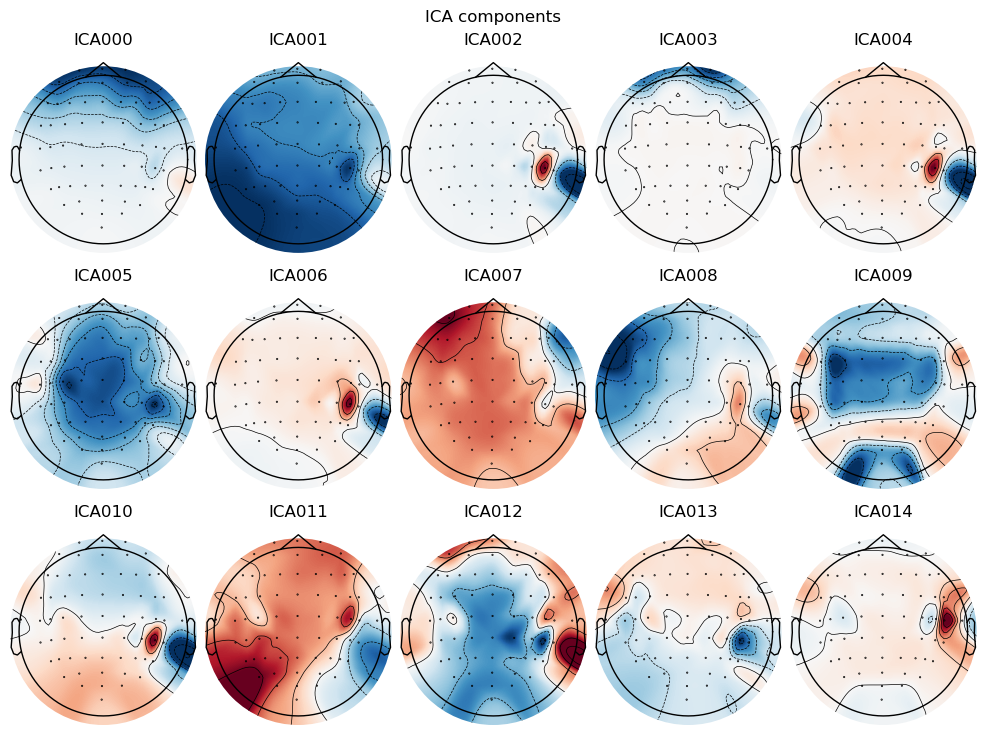

In [27]:
ica.plot_components();

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


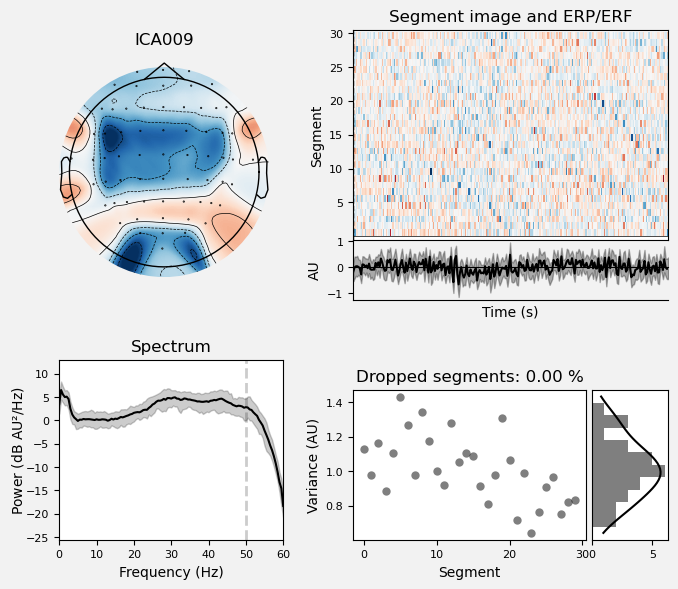

In [30]:
ica.plot_properties(raw, picks=9); # This exact component number probably won't work if you recompute ICA


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


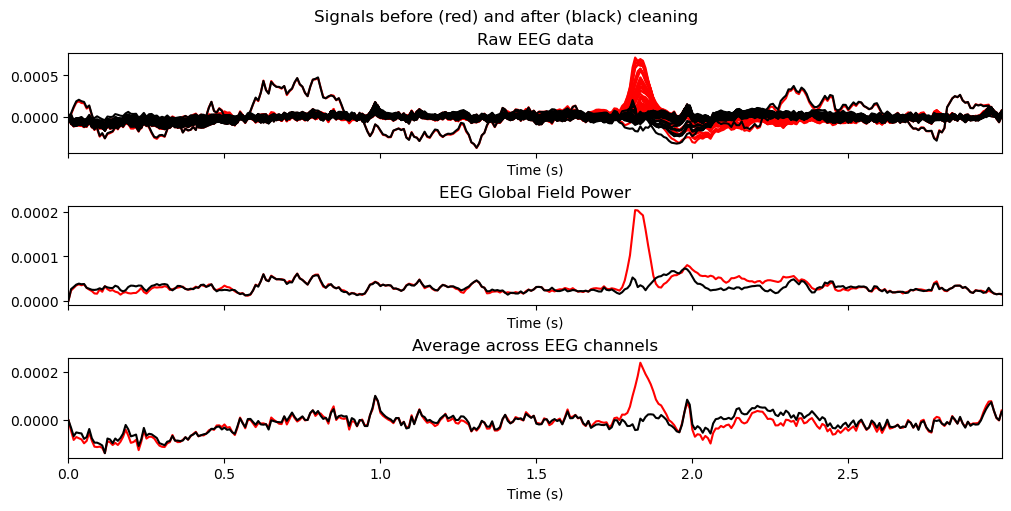

In [31]:
# With bad component removed
ica.plot_overlay(raw, exclude=[0]);

In [32]:
ica.exclude = [0]
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


<RawEDF | S003R01.edf, 64 x 7320 (61.0 s), ~3.7 MiB, data loaded>

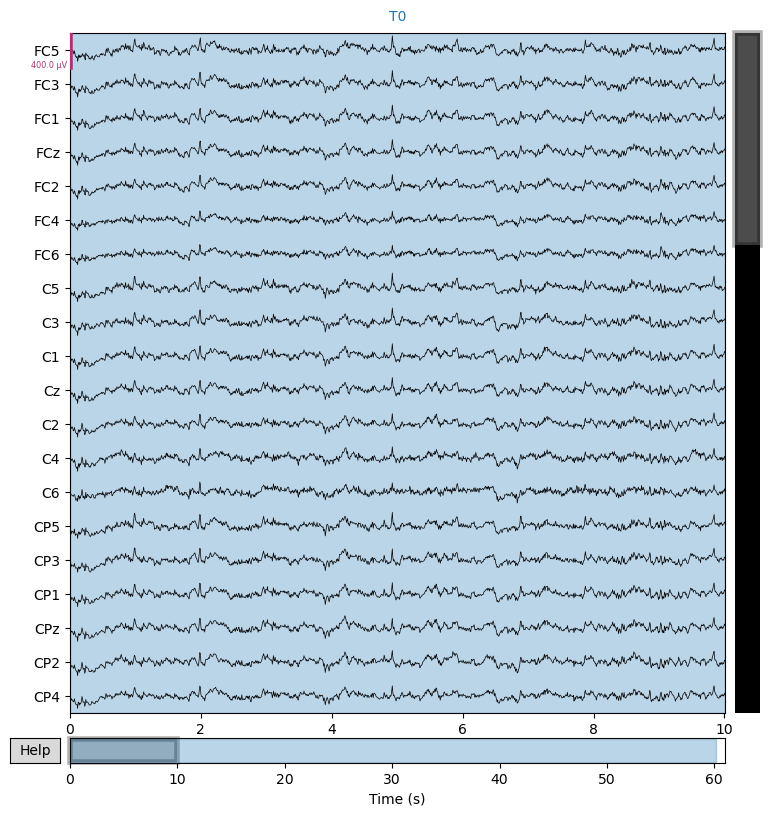

In [33]:
raw.plot(scalings=dict(eeg=200e-6));